# Randomized Benchmarking

## 1. Introduction

量子情報処理装置を構築する上での主な課題の1つは、プロセストモグラフィーを介して量子システムに影響を与えるノイズを完全に特徴付けることの非拡張性です。さらに、プロセストモグラフィは、回転前および回転後のゲートのノイズと測定値
(SPAMエラー)に敏感です。ゲートセット断層撮影はこれらの誤差を考慮に入れることができますが、スケーリングはさらに悪いです。ノイズの完全な特性評価は、優れたエラー訂正方式の決定を可能にし、従って量子情報の信頼できる伝送の可能性をもたらすため、有用です。

大規模システムでは完全なプロセストモグラフィーが実行不可能であるため、量子システムに影響を与えるノイズを部分的に特徴付けるためのスケーラブルな方法への関心が高まっています。ランダム化手法を使用して単一のパラメーターでクリフォードゲートの完全なセットをベンチマークするためのスケーラブルな(システムを構成するqubitの数n)およびロバストなアルゴリズムは、以下に示されています。量子ゲートのベンチマークにランダム化手法を使用する概念は、一般にRandomized Benchmarking(ランダム化ベンチマーク(RB))と呼ばれます。

https://arxiv.org/pdf/1009.3639.pdf

## 2. The Randomized Benchmarking Protocol

まず、デモに関連するqiskitクラスをインポートする必要があります。

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

RBプロトコルは、次のステップで構成されています。

### Step 1:Generate RB sequences

RBシーケンスは、qubitを初期状態に戻る必要がある計算された反転要素を含む、$n$qubit上の"Clifford group"(クリフォードグループ)から一様に選択されたランダムクリフォード要素で構成されます。

より正確には、各長さ$m$に対して、$K_m$RBシーケンスを選択します。そのような各シーケンスには、$n$-qubitのクリフォードグループから一様に選択された$m$個のランダム要素$C_{i_j}$が含まれ、$m+1$要素は次のように定義されます。$C_{i_{m+1}}=(C_{i_1}\ldots C_{i_m})^{-1}$。Gottesmann-Knillの定理によって効率的に見つけることができます。

例えば、2qubitクリフォード回路のいくつかのシーケンスを生成します。

In [2]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ=2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5
#Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

Making the n=2 Clifford Table


例として、最初のRBシーケンスに対応する回路をプリントします。

In [3]:
rb_circs[0][0].draw()

┌───┐┌───┐     ┌─────┐┌───┐┌───┐ ░ ┌───┐ ┌───┐ ┌───┐     ┌─────┐┌───┐┌─┐
qr_0: ┤ H ├┤ S ├──■──┤ SDG ├┤ H ├┤ X ├─░─┤ X ├─┤ H ├─┤ S ├──■──┤ SDG ├┤ H ├┤M├
      └───┘└───┘┌─┴─┐└┬───┬┘├───┤├───┤ ░ ├───┤┌┴───┴┐├───┤┌─┴─┐└─┬─┬─┘└───┘└╥┘
qr_1: ──────────┤ X ├─┤ H ├─┤ S ├┤ X ├─░─┤ X ├┤ SDG ├┤ H ├┤ X ├──┤M├────────╫─
                └───┘ └───┘ └───┘└───┘ ░ └───┘└─────┘└───┘└───┘  └╥┘        ║ 
cr_0: ════════════════════════════════════════════════════════════╬═════════╩═
                                                                  ║           
cr_1: ════════════════════════════════════════════════════════════╩═══════════

各RB回路を表すユニタリーが(グローバルフェーズで)同一であることを確認できます。Aerユニタリーシミュレーターを使用してこれをシミュレートします。

In [4]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [12]:
# The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
from qiskit_textbook.tools import array_to_latex
array_to_latex(np.around(job.result().get_unitary(),3), pretext="\\text{Unitary} = ")

<IPython.core.display.Math object>

### Step 2 : Execute the RB sequences(with some noise)

Qiskit Aer Simulator(ノイズモデルあり)または、IBMQプロバイダーを使用してRBシーケンスを実行し、結果のリストを取得できます。

仮定により、各操作$C_{i_j}$には$Λ_{{i_j},j}$で表されるエラーが許可されており、各シーケンスは操作によってモデル化できます。

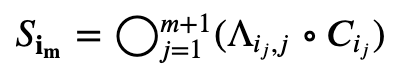

ここで、$im=(i_1,\ldots,i_m)$および$i_{m+1}$は$i_m$によって一意に決定されます。

In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('qasm_simulator')

### Step 3 : Get statistics about the survival probabilities

各$K_m$シーケンスについて、生存確率$Tr[E_ψS_{i_m}(𝜌_ψ)]$が測定されます。ここで、$𝜌_ψ$は準備エラーを考慮した初期状態、$E_ψ$は測定エラーを考慮したPOVM要素です。理想的な(ノイズのない)場合$𝜌_ψ=E_ψ=|ψ\rangle\langleψ|$となる。

実際には、正確な初期状態に戻る確率、つまり基底状態$|00\ldots0\rangle$の全てのqubit、またはqubitの1つが基底状態に戻る確率のみを想定できます。相関測定方式が不可能な場合は、qubitを個別に測定する方が便利です。両方の測定値は、回転の特性に従って同じ減衰パラメータに適合します。

### Step 4 : Find the averaged sequence fidelity

平均化されたシーケンスの忠実度を見つけるために、シーケンスの$K_m$ランダムな実現全体の平均

$F_{seq}(m,|ψ\rangle)=Tr[E_ψS_{K_m}(\rho_ψ)]$

where

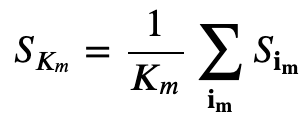

は平均シーケンス操作です。

### Step 5 : Fit the results

$m$の異なる値に対して手順1〜4を繰り返し、平均化されたシーケンスの忠実度の結果をモデルに近似します。

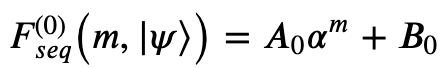

ここで、$A_0$と$B_0$は、状態の準備と測定のエラー、および最終ゲートのエラーによるエッジ効果を吸収します。

$α$は、平均エラー率$r$を決定します。これは、次の関係に従って"Error per Clifford(EPC)"とも呼ばれます。

$r=1-α-\frac{1-α}{2^n}=\frac{2^n-1}{2^n}(1-α)$

(ここで$n=nQ$はqubitの数です。)

例として、各RBシーケンスの平均シーケンス忠実度を計算し、結果を指数曲線に適合させ、パラメーター$α$とEPCを計算します。

In [7]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(new_rb_circ_seed, backend, shots=shots,
                         noise_model=noise_model,
                         backend_options={'max_parallel_experiments': 0})    
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.981041, EPC: 0.014219
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.981471, EPC: 0.013897
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.979005, EPC: 0.015746
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.979514, EPC: 0.015365
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.980040, EPC: 0.014970


#### Extra Step : Plot the reslts

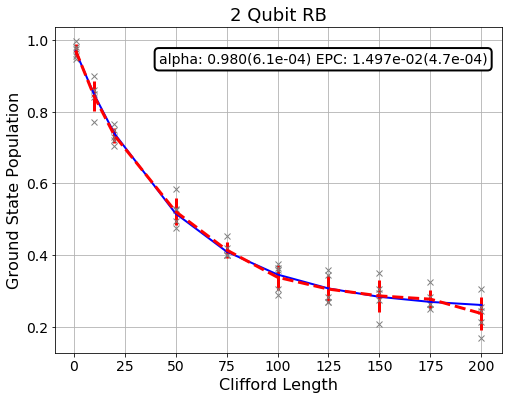

In [8]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

## 3. The Intuition Behind RB

"Depolarizing quantum channel"(偏光解消量子チャネル)にはパラメータ$\alpha$があり、次のように機能します。確率$\alpha$では、状態は依然と同じままです。確率$1-\alpha$で、状態は完全に混合された状態になります。

$\rho_f=\alpha\rho_i + \frac{1-\alpha}{2^n}*I$

一連の$m$個のゲートがあるとします。必ずしもクリフォードゲートではありません。ゲートのエラーチャネルは、パラメータ$\alpha$(全てのゲートで同じ$\alpha$)を持つ脱分極チャネルです。次に、確率$\alpha^m$では状態はシーケンスの最後で正しく、確率$1-\alpha^m$では完全に混合された状態になるため、次のようになります。

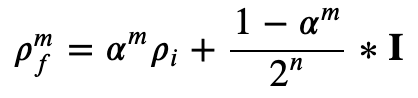

さらに、基底状態から始めると仮定します。シーケンス全体が同一性に相当すること。そして、シーケンスの最後の状態を標準ベースで測定します。シーケンスの最後に成功する確率は次の通りです。

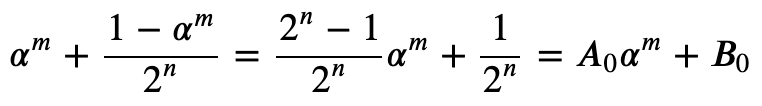

従って、成功の確率、つまり忠実度は、指数$\alpha$で、シーケンスの長さとともに指数関数的に減衰します。

チャネルがdepolarizing channel以外の場合、最後のステートメントは必ずしも当てはまりません。ただし、ゲートが均一にランダム化されたクリフォードゲートである場合、各ゲートのノイズは、チャネルから計算できる幾つかのパラメーターを使用して、depolarizing channelであるかのように平均して動作し、フィデリティの指数関数的減衰が得られることがわかります。

正式には、量子チャネル$\Lambda$の有限グループ$G$(クリフォードグループなど)の平均を取ることは、"twirl"(トワール)とも呼ばれます。

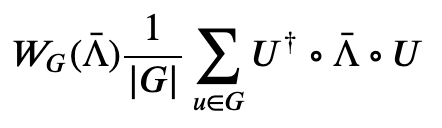

ユニタリーグループ全体を回すと、クリフォードグループと全く同じ結果になります。クリフォードグループはユニタリーグループの2つのデザインです。

## 4. Simultaneous Raandomized Benchmarking

RBは、マルチキュービットシステムの忠実度に2つの方法で対処するように設計されています。1つは、$n$-qubit空間全体のRBは、$n$-qubitクリフォードグループからシーケンスを作成することで実行できます。さらに、$n$-qubit空間は、各サブセットで同時に実行されるqubit{$n_i$}と$n_i$-qubitRBのセットに再分割できます。どちらの方法でも、$n$-qubit空間でのフィデリティの指標が得られます。

例えば、CNOTゲートを定義する2qubitのサブセットで2Q RBを実行し、他のqubitは静止しているのが一般的です。このRBデータは他のqubit部分空間が回転されないため、必ずしも指数関数的に減衰しません。サブセットは、同時RBにより厳密に特徴付けられます。これは、全てのqubitがアクティブであるため、ある程度のクロストークエラーも測定します。

同時RB(1Q RBおよび2Q RB)の例は、次の場所にあります。<br>
https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/noise/4_randomized_benchmarking.ipynb

## 5. Predicted Gate Fidelity

基礎となるゲート(ゲートセット)のエラーがわかっている場合は、RB実験を実行せずにEPCを予測できます。この計算により、RB実験とそれに続くフィッティングにより正しいEPC値が得られることが確認されます。まず、クリフォードあたりのこれらのゲートの数を数える必要があります。

次に、2つのqubitクリフォードゲート誤差関数calculate_2q_epcにより、2Qクリフォードあたりの誤差が得られます。下にあるゲートの誤差が減極していることを前提としています。

In [9]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.227074
Number of u2 gates per Clifford: 1.286681
Number of u3 gates per Clifford: 0.190175
Number of cx gates per Clifford: 1.552838


In [10]:
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gate_per_cliff,
    epg_2q=epg_q01,
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per Clifford: %e (qasm simulator result: %e)" % (pred_epc, rb_fit.fit[0]['epc']))

Predicted 2Q Error per Clifford: 1.554632e-02 (qasm simulator result: 1.496986e-02)


一方、実験的に得られたEPCから、基礎となるゲート(ゲートセット)の誤差を計算できます。RBシーケンスの全てのシングルキュービットゲートのエラーがわかっている場合、2つのキュービットRB実験のEPCから2Qゲートエラーを予測できます。

2つのqubitゲートエラー関数calculate_2q_epgは、2Qゲートあたりのエラーの推定値を提供します。このセクションでは、"deporalizing error model"(脱分極化エラーモデル)を使用して単一キュービットエラーを準備します。エラーモデルが不明な場合、これらのゲートのEPG、例えば[$u_1,u_2,u_3$]は、ユーティリティ関数calculate_1q_epgを使用した別の1Q RB実験で推定できます。

In [11]:
# use 2Q EPC from qasm simulator result and 1Q EPGs from depolarizing error model
pred_epg = rb.rb_utils.calculate_2q_epg(
    gate_per_cliff=gate_per_cliff,
    epc_2q=rb_fit.fit[0]['epc'],
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per gate: %e (gate error model: %e)" % (pred_epg, epg_q01))

Predicted 2Q Error per gate: 7.106019e-03 (gate error model: 7.500000e-03)
